In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob

%matplotlib inline

In [2]:
IMG_SIZE = 192

In [3]:
images = np.array([cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)) for i in glob("leedsbutterfly\\images/*")])
masks = np.array([cv2.resize(cv2.imread(i),(IMG_SIZE,IMG_SIZE)) for i in glob("leedsbutterfly\\segmentations/*")])

In [4]:
images = images / 255
masks = masks / 255

In [5]:
masks_bin = (masks.mean(axis=3).reshape(-1,IMG_SIZE,IMG_SIZE,1) > 0.).astype(np.uint8)

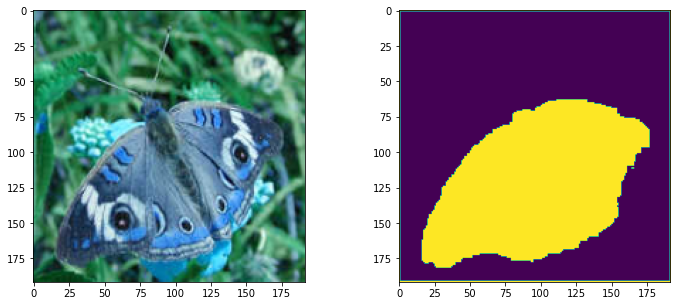

In [6]:
i = np.random.randint(len(images))
img,mask = images[i].copy(),masks_bin[i].copy()

fig,axes = plt.subplots(1,2,figsize=(12,5))
axes[0].imshow(img)
axes[1].imshow(mask.reshape(IMG_SIZE,IMG_SIZE))

In [7]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *

In [8]:
inp = Input(shape=images[0].shape)

conv = Conv2D(32,3,activation="relu",padding="same")(inp)
conv = Conv2D(32,3,activation="relu",padding="same")(conv)
batch = BatchNormalization()(conv)
pool = MaxPool2D()(batch)

conv = Conv2D(64,3,activation="relu",padding="same")(pool)
conv = Conv2D(64,3,activation="relu",padding="same")(conv)
batch = BatchNormalization()(conv)
pool = MaxPool2D()(batch)

conv = Conv2D(128,3,activation="relu",padding="same")(pool)
conv = Conv2D(128,3,activation="relu",padding="same")(conv)
batch = BatchNormalization()(conv)
pool = MaxPool2D()(batch)

conv = Conv2D(256,1,activation="relu",padding="same")(pool)
pool = MaxPool2D()(conv)
neck = Flatten()(pool)
neck = Dense(1024,activation="relu")(neck)
neck = Dense(36864,activation="relu")(neck)
neck = tf.reshape(neck,(-1,12,12,256))
convt = Conv2DTranspose(256,1,activation="relu",strides=2,padding="same")(neck)

convt = Conv2DTranspose(128,3,activation="relu",padding="same")(convt)
convt = Conv2DTranspose(128,3,activation="relu",strides=2,padding="same")(convt)
batch = BatchNormalization()(convt)

convt = Conv2DTranspose(64,3,activation="relu",padding="same")(batch)
convt = Conv2DTranspose(64,3,activation="relu",strides=2,padding="same")(convt)
batch = BatchNormalization()(convt)

convt = Conv2DTranspose(32,3,activation="relu",strides=2,padding="same")(batch)
convt = Conv2DTranspose(32,3,activation="relu",padding="same")(convt)
batch = BatchNormalization()(convt)

convt = Conv2DTranspose(3,3,activation="relu",strides=2,padding="same")(batch)
out = Conv2D(1,1,strides=2,padding="same",activation="sigmoid")(convt)

model = keras.Model(inp,out,name="conv_auto_encoder")

In [9]:
model.summary()

Model: "conv_auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 64)  

In [10]:
index =  np.arange(0,len(images))
np.random.shuffle(index)

X,Y = images[index],masks_bin[index]

In [11]:
model.compile(optimizer="adam",loss="binary_crossentropy")

In [12]:
grid = [
    [8,10],
    [4,15],
    [2,20],
    [1,25]
]

In [13]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath="checkpoints/conv_auto_encoder",
        save_weights_only=True,
        monitor='loss',
        save_best_only=True,
    )

In [14]:
hist = []

for batch_size,epochs in grid:
    history = model.fit(X,Y,batch_size=batch_size,epochs=epochs,callbacks=[model_checkpoint_callback])
    hist.append(history)

Train on 832 samples
Epoch 1/10
832/832 [==============================] - 26s 32ms/sample - loss: 0.4145
Epoch 2/10
832/832 [==============================] - 23s 27ms/sample - loss: 0.2802
Epoch 3/10
832/832 [==============================] - 22s 27ms/sample - loss: 0.2272
Epoch 4/10
832/832 [==============================] - 23s 28ms/sample - loss: 0.2052
Epoch 5/10
832/832 [==============================] - 23s 28ms/sample - loss: 0.1766
Epoch 6/10
832/832 [==============================] - 21s 26ms/sample - loss: 0.1561
Epoch 7/10
832/832 [==============================] - 21s 26ms/sample - loss: 0.1418
Epoch 8/10
832/832 [==============================] - 24s 29ms/sample - loss: 0.1305
Epoch 9/10
832/832 [==============================] - 26s 31ms/sample - loss: 0.1164
Epoch 10/10
832/832 [==============================] - 29s 34ms/sample - loss: 0.1059
Train on 832 samples
Epoch 1/15
832/832 [==============================] - 30s 36ms/sample - loss: 0.1262
Epoch 2/15
832/832 [==

KeyboardInterrupt: 

In [119]:
alpha_c = np.ones((IMG_SIZE,IMG_SIZE,3)) * np.array([1,0,0])

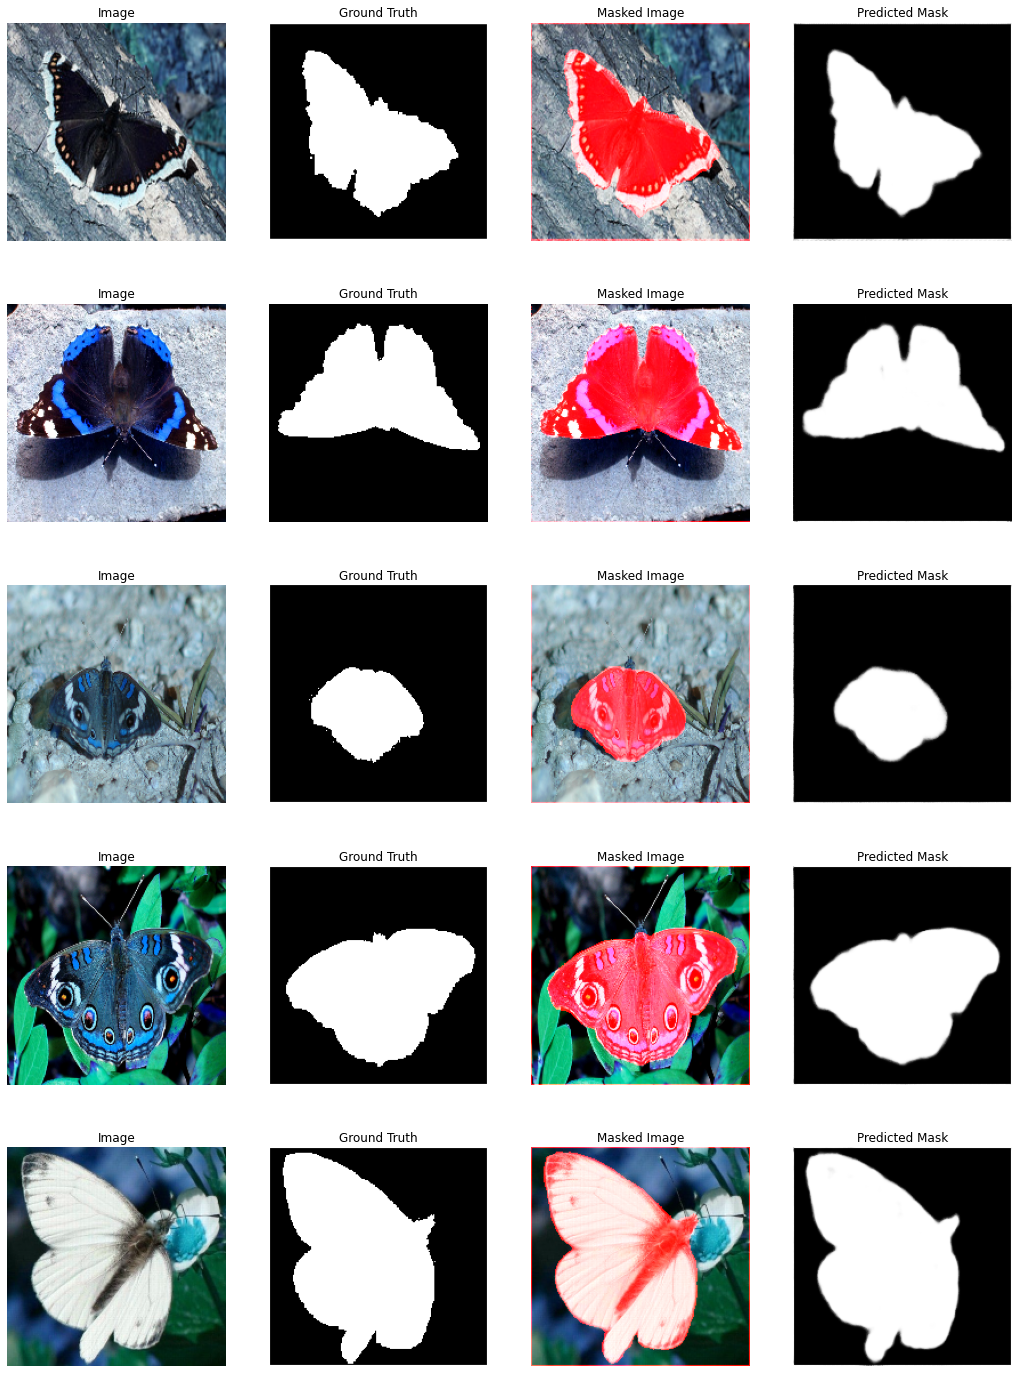

In [205]:
ind = np.random.randint(len(images),size=(5,))

fig,axes = plt.subplots(5,4,figsize=(18,25))

for i,(a0,a1,a2,a3) in zip(ind,axes):
    img,mask = images[i].copy(),masks_bin[i].copy()
    pred = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3)).reshape(IMG_SIZE,IMG_SIZE)
        
    masked = img.copy()
    box = masked[pred > 0.1].copy()
    box[:,0] = 1
    masked[pred > 0.1] = box
    
    a0.imshow(img)
    a0.set_title("Image")
    a0.axis("off")

    a1.imshow(mask.reshape(IMG_SIZE,IMG_SIZE),cmap="gray")
    a1.set_title("Ground Truth")
    a1.axis("off")

    
    a2.imshow(masked)
    a2.set_title("Masked Image")
    a2.axis("off")
     
    a3.imshow(pred,cmap="gray")
    a3.set_title("Predicted Mask")
    a3.axis("off")